# Module 7: Random Process and Monte Carlo Methods

### PROBLEM 1
**Integration with Monte Carlo methods**

_Refer to Exercise 10.5 in the Newman text_ 

1. Evaluate this integral 
$$ I = \int_0^2 \sin^2\left[\frac{1}{x(2-x)}\right] {\rm d}x.$$
using the "hit-or-miss" Monte Carlo method of Section 10.2 with 10,000 points. Also evaluate the error on your estimate. *(15 pts.)*

2. Now estimate the integral again using the mean value method with 10,000 points. Also evaluate the error. *(15 pts.)*

1. We calculate the integral using the "hit-or-miss" Monte Carlo method adapting the code ```mcint.py``` from the Newman text. We use $N=10,000$ random points.

In [ ]:
import math 
import random 
import numpy as np

# define the integrand
def f(x): 
  return (np.sin(1/(x*(2-x))))**2 #insert equation here

# set random seed
random.seed(123) #this is optional, you can opt to seed your random numbers to make sure that you get a fixed set of random numbers muna

N = 10000 # set number of random points
count = 0 # initialize counter of points within the area under the curve
for i in range(N):  # get random x,y and update count    
  x = 2*random.random()#get random x
  y = random.random()#get random y
  if y<f(x):          
    count += 1 

I = 2*count/N # calculate integral
print(I)

1.4254


The expected error on the integral $I$ from the "hit-and-miss" method is:
\begin{equation}
\sigma = \frac{\sqrt{I(A-I)}}{\sqrt{N}},
\end{equation}
where $A$ is the area of the bounding rectangle.

In [ ]:
A = 2 
sigma = np.sqrt(I*(A-I))/np.sqrt(N) #insert the equation
print(sigma)

0.009050054364477596


2. We calculate the same integral using the mean value method with the same $N = 10,000$.

In [ ]:
f_sum, fsq_sum = 0, 0

for i in range(N):
  x = 2*random.random()# get random number between [0,2)
  f_sum += f(x)# get sum
  fsq_sum += f(x)**2 # get sum of squares

I2 = 2*f_sum/N#here we use equation 10.30 from the book
print(I2) 

1.4446079067246547


The expected error on the integral from the mean value method is:
\begin{equation}
\sigma = (b-a)\frac{\sqrt{{\rm var} f}}{\sqrt{N}}.
\end{equation}

In [ ]:
varf = fsq_sum/N-(f_sum/N)**2 #compute for the variance
sigma2 = 2*np.sqrt(varf/N)#compute sigma using equation above
print(sigma2)

0.005302385014768019


As expected, this is smaller than the expected error from the "hit-and-miss" Monte Carlo method.

### PROBLEM 2
**The Ising model**

_Refer to Exercise 10.9 in the Newman text._ The Ising model is a theoretical model of a magnet. The magnetic potential energy due to the interaction of two dipoles is proportional to their dot product, but in the Ising model this simplifies to just the product $s_i s_j$ for spins on sites $i$ and $j$ of the lattice, since the spins are one-dimensional scalars, not vectors. Then the actual energy of interaction is $-Js_i s_j$, where $J$ is a positive interaction constant. The minus sign ensures that the in- teractions are ferromagnetic, meaning the energy is lower when dipoles are lined up. A ferromagnetic interaction implies that the material will magnetize if given the chance.

Normally it is assumed that spins interact only with those that are immediately adjacent to them on the lattice, which gives a total energy for the entire system equal to
$$ E = -J \sum_{\langle ij \rangle} s_i s_j,$$
where the notation $\langle ij \rangle$ indicates a sum over pairs $i,j$ that are adjacent on the lattice. On the square lattice we use in this exercise each spin has four adjacent neighbors with which it interacts, except for the spins at the edges of the lattice, which have either two or three neighbors.

Perform a Markov chain Monte Carlo simulation of the Ising model on the square lattice for a system of 20 x 20 spins. You will need to set up variables to hold the value ±1 of the spin on each lattice site, probably using a two-dimensional integer array, and then take the following steps.

1. Write a function to calculate the total energy of the system, as given by the equation above. That is, for a given array of values of the spins, go through every pair of adjacent spins and add up the contributions $s_i s_j$ from all of them, then multiply by $-J$. Hint 1: Each unique pair of adjacent spins crops up only once in the sum. Thus there is a term $-Js_1s_2$ if spins 1 and 2 are adjacent to one another, but you do not also need a term $-Js_2s_1$. Hint 2: To make your final program to run in a reasonable amount of time, you will find it helpful if you can work out a way to calculate the energy using Python's ability to do arithmetic with entire arrays at once. If you do the calculation step by step, your program will be significantly slower. *(20 pts.)*

2. Now use your function as the basis for a Metropolis-style simulation of the Ising model with $J = 1$ and temperature $T = 1$ in units where the Boltzmann constant $k_B$ is also 1. Initially set the spin variables randomly to ±1, so that on average about a half of them are up and a half down, giving a total magneti- zation of roughly zero. Then choose a spin at random, flip it, and calculate the new energy after it is flipped, and hence also the change in energy as a result of the flip. Then decide whether to accept the flip using the Metropolis acceptance formula, Eq. (10.60). If the move is rejected you will have to flip the spin back to where it was. Otherwise you keep the flipped spip. Now repeat this process for many moves. *(20 pts.)*

3. Make a plot of the total magnetization $M = \sum_i s_i$ of the system as a function of time for a million Monte Carlo steps. You should see that the system develops a "spontaneous magnetization," a nonzero value of the overall magnetization. Hint: While you are working on your program, do shorter runs, of maybe ten thousand steps at a time. Once you have it working properly, do a longer run of a million steps to get the final results. *(20 pts.)*

4. Run your program several times and observe the sign of the magnetization that develops, positive or negative. Describe what you find and give a brief explana- tion of what is happening. *(10 pts.)*

In [129]:
def total_energy(state, J): #not periodic
  N = len(state) # size of lattice
  energy = 0     # initialize energy
  #try drawing this first so that you'll know the values of si_sj (be careful with your indexing)
  for i in np.arange(N):
    for j in np.arange(N): 
      if i<=j:
        # case1: 4 corner cells - have 2 adjacent cells 
        if (i==0) & (j==0): 
          si_sj = state[i,j]*(state[i,j+1]+state[i+1,j])
        elif (i==0) & (j==N-1):
          si_sj = state[i,j]*state[i+1,j]
        elif (i==N-1) & (j==0):
          si_sj = state[i,j]*state[i,j+1]
        elif (i==N-1 & j==N-1):
          si_sj = 0
        # case2: side cells - have 3 adjacent cells
        elif i==0:
            si_sj = state[i,j]*(state[i+1,j]+state[i,j+1])
        elif j==0:
            si_sj = state[i,j]*(state[i+1,j]+state[i,j+1])
        elif i==N-1:
          si_sj = state[i,j+1]*state[i,j+1]
        elif j==N-1:
          si_sj = state[i,j]*state[i+1,j]
        # case3: inner cells - have 4 adjacent cells
        else: 
          si_sj = state[i,j]*(state[i+1,j]+state[i,j+1])
        energy += -1.*si_sj
  return J*energy 

In [130]:
import numpy as np
def delta_E(y,x, state):
    state=np.copy(state)
    E_i = total_energy(state,1)
    state[y,x] = -state[y,x] #flip the chosen random state
    E_j = total_energy(state,1) #calculate new energy after flipping
    return E_j-E_i #return difference of the two energies

In [131]:
from numpy import random
def metropolis_flip(change_E,y,x,state):
    global k_B
    global T
    beta = 1/(k_B*T) #define beta
    if random.random()<np.exp(-beta*change_E):
      state[y,x] = -state[y,x]
    return state

In [132]:
def magnetization(state): #calculate the total magnetization of the system
    global N
    return np.sum(state)/N

In [135]:
N = 20 #size of lattice
J = 1 #interaction constant
k_B = 1 #Boltzmann constant
T = 1 #Temperature

state = random.choice([1,-1],(N,N)) #define NxN lattice which contains 1 or -1 (hint: use numpy.random package)

iterations = 10000 #set number of iterations required (use small values to start)
M = []
for i in range(iterations+1):
    y,x =  random.randint(0,N,2) #choose a random spin from the lattice
    change_E = delta_E(y,x,state) #calculate the change in energy
    state = metropolis_flip(change_E,y,x,state) #decide whether to flip the state or not
    total_magnetization = magnetization(state) #compute magnetization of the whole lattice
    M.append(total_magnetization)

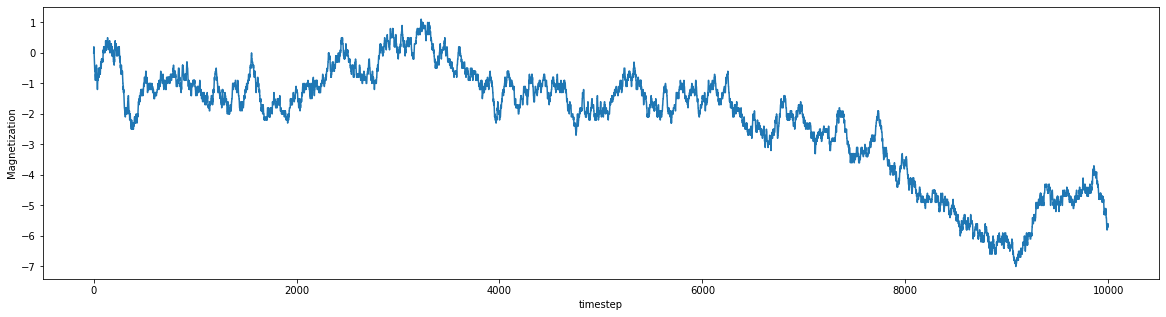

In [136]:
import matplotlib.pyplot as plt
#plot magnetization
plt.figure(figsize=(20,5))
plt.plot(M)
plt.xlabel("timestep")
plt.ylabel("Magnetization")
plt.show()